In [4]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn import datasets, linear_model, metrics
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load the data
#df_all = pd.read_csv('data/220306_slugs_dataset.csv')
df_all = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220306_slugs_dataset.csv')
df_inp = df_all.drop(['loadCase', 'out_supReac_kN_n3', 'out_supReac_kN_n4', 'out_verDisp_mm_n5'], axis=1)
df_inp = df_inp.dropna()

# Create some new features
df_inp['densDiff'] = df_inp['slugDen'] - df_inp['pockDen']
df_inp['centrFor'] = df_inp['slugVel']**2 * df_inp['densDiff']

## Data Scaling & Splitting

In [7]:
df_scl = df_inp.copy(deep=True)
scaler = preprocessing.StandardScaler() # Scale using standard deviation
df_scl = pd.DataFrame(scaler.fit_transform(df_scl), columns = df_scl.columns, index = df_scl.index)

# Create percentile field for sratification
df_scl['splits'] = pd.qcut(df_scl['out_oopDisp_mm_n2'], 100, labels=False)

# Create train and test splits (20% test)
train, test = train_test_split(df_scl, test_size=0.20, stratify=df_scl['splits'], random_state=0) 

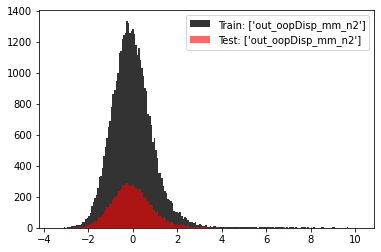

Max (train) =  10.2
Max (test) =  8.5


In [8]:
# Verify that stratification has been effective
n_bins = 200
param = ['out_oopDisp_mm_n2']
fig, axs = plt.subplots(figsize = (6, 4))
axs.hist(train[param].values, bins=n_bins, label = f'Train: {param}', color = 'black', alpha=0.8, zorder=1)
axs.hist(test[param].values, bins=n_bins, label = f'Test: {param}', color = 'red', alpha=0.6, zorder=2)
axs.legend(loc = 'upper right')
plt.show()
print('Max (train) = ', round(train[param].values.max(), 1))
print('Max (test) = ', round(test[param].values.max(), 1))

In [9]:
# Drop the splits column
train = train.drop(['splits'], axis=1)
test = test.drop(['splits'], axis=1)

## NN - Multi-output

In [10]:
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

In [11]:
pred_target = ['out_oopDisp_mm_n2', 'out_oopDisp_mm_n5', 'out_endBend_kNm_n6']
pred_features = [
    'slugDen',  # 0
    'slugLen',  # 1
    'pockDen',  # 2
    'pockLen',  # 3
    'slugVel',  # 4
    'basePer',  # 5
    'baseAmp',  # 6
    'basePha',  # 7
    'simTime',  # 8
    'densDiff', # 9
    'centrFor'  # 10
]
pred_features = pred_features[:]
X_train = train.filter(pred_features)
y_train = train.filter(pred_target)
X_test = test.filter(pred_features)
y_test = test.filter(pred_target)

In [10]:
clf = MLPRegressor(random_state=1, max_iter=3000).fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = clf.predict(X_test.to_numpy())

In [11]:
y_bas = df_inp[pred_target].to_numpy()
scaler_m = preprocessing.StandardScaler()
y_scl = scaler_m.fit_transform(y_bas)

In [12]:
# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_test)
yhat = scaler_m.inverse_transform(y_pred)

for target in range(3):
    y_t = y[:, target]
    yhat_t = yhat[:, target]

    globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
    globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
    globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5)  
    r2 = metrics.r2_score(y_t, yhat_t)

    print(f'\nTarget {target+1}: Results of sklearn.metrics:')
    print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
    print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
    print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
    print("R-Squared:", round(r2, 2))


Target 1: Results of sklearn.metrics:
MAE: 5.16
MSE: 51.89
RMSE: 7.2
R-Squared: 0.94

Target 2: Results of sklearn.metrics:
MAE: 8.59
MSE: 144.1
RMSE: 12.0
R-Squared: 0.92

Target 3: Results of sklearn.metrics:
MAE: 14.57
MSE: 366.98
RMSE: 19.16
R-Squared: 0.89


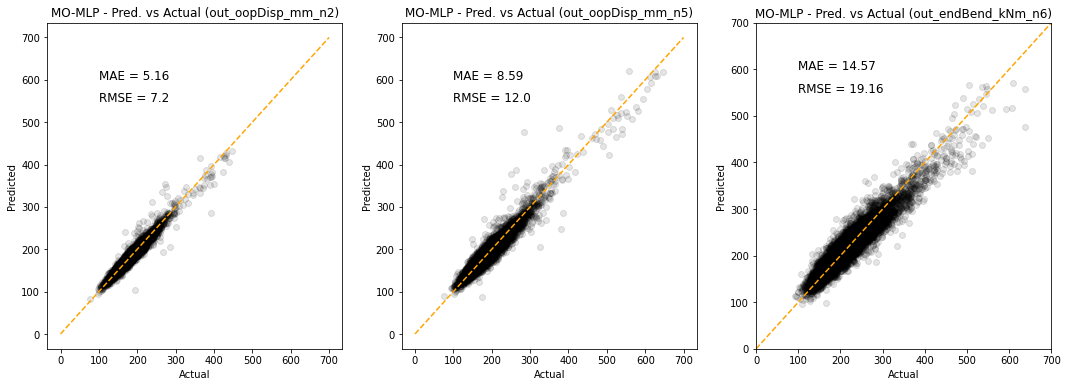

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

for p in range(3):
    mae = round(globals()[f'mae_momlp_{p}'], 2)
    rmse = round(globals()[f'rmse_momlp_{p}'], 2)
    ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
    ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
    ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
    ax[p].set_title(f'MO-MLP - Pred. vs Actual ({pred_target[p]})')
    ax[p].text(100, 600, f'MAE = {round(mae, 2)}', fontsize = 12)
    ax[p].text(100, 550, f'RMSE = {round(rmse, 2)}', fontsize = 12)

plt.xlim(0, 700)
plt.ylim(0, 700)

plt.show()

## NN Experiments

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

In [98]:
model_track = []
mae_track1, mae_track2, mae_track3 = ([], [], [])
rmse_track1, rmse_track2, rmse_track3 = ([], [], [])

In [99]:
def gen_model1(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(256, input_dim=n_inputs, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(512, activation='relu'))   
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))    
    model.add(Dense(n_outputs, activation='linear'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [100]:
def gen_model2(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [101]:
def gen_model3(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(100, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [102]:
def gen_model4(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [103]:
def gen_model5(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(60, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [104]:
def gen_model6(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [105]:
def gen_model7(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))
    model.add(Dense(9, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [106]:
def gen_model8(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))
    model.add(Dense(9, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [107]:
def gen_model9(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu')) 
    model.add(Dense(40, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(9, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [171]:
def gen_model10(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(50, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [179]:
def gen_model11(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.008)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [187]:
def gen_model12(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [195]:
def gen_model13(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [203]:
def gen_model14(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(90, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(30, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [211]:
def gen_model15(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(76, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(38, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [216]:
# Loop through and fit each model and collect performance results.
for m_num  in range(15):
    # Generate the model
    n_inputs, n_outputs = X_train.to_numpy().shape[1], y_train.to_numpy().shape[1]
    model_num = m_num + 1
    gen_model = globals()[f'gen_model{model_num}']
    nn_model = gen_model(n_inputs, n_outputs)
    model_track.append(model_num)

    # Fit the model
    history = nn_model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=300, batch_size=128, validation_split=0.20, verbose=0).history

    # Plot the training losses
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history['loss'], 'grey', label='Train', linewidth=2)
    ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

    # Make predictions on test data
    y_pred = nn_model.predict(X_test.to_numpy())
    y_bas = df_inp[pred_target].to_numpy()
    scaler_m = preprocessing.StandardScaler()
    y_scl = scaler_m.fit_transform(y_bas)

    # Inverse transform (scaling) to review metrics such as MAE
    y = scaler_m.inverse_transform(y_test)
    yhat = scaler_m.inverse_transform(y_pred)

    # Print metrics
    for target in range(3):
        y_t = y[:, target]
        yhat_t = yhat[:, target]

        globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
        globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
        globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5)  
        r2 = metrics.r2_score(y_t, yhat_t)

        print(f'\nTarget {target+1}: Results of sklearn.metrics:')
        print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
        print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
        print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
        print("R-Squared:", round(r2, 2))
        globals()[f'mae_track{target+1}'].append(round(globals()[f'mae_momlp_{target}'], 2))
        globals()[f'rmse_track{target+1}'].append(round(globals()[f'rmse_momlp_{target}'], 2))

    # Plot performance
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    for p in range(3):
        mae = round(globals()[f'mae_momlp_{p}'], 2)
        rmse = round(globals()[f'rmse_momlp_{p}'], 2)
        ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
        ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
        ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
        ax[p].set_title(f'MO-MLP - Pred. vs Actual ({pred_target[p]})')
        ax[p].text(100, 600, f'MAE = {round(mae, 2)}', fontsize = 12)
        ax[p].text(100, 550, f'RMSE = {round(rmse, 2)}', fontsize = 12)

    plt.xlim(0, 700)
    plt.ylim(0, 700)
    plt.show()


Target 1: Results of sklearn.metrics:
MAE: 3.93
MSE: 28.01
RMSE: 5.29
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.12
MSE: 71.68
RMSE: 8.47
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 10.83
MSE: 206.65
RMSE: 14.38
R-Squared: 0.94


In [218]:
# Model tracking dataframe summary
experiments = pd.DataFrame(data=model_track, columns=['model_ref'])
experiments['mae1'] = mae_track1
experiments['mae2'] = mae_track2
experiments['mae3'] = mae_track3
experiments['rmse1'] = rmse_track1
experiments['rmse2'] = rmse_track2
experiments['rmse3'] = rmse_track3
experiments

,model_ref,mae1,mae2,mae3,rmse1,rmse2,rmse3
0,1,10.69,15.21,23.70,15.24,23.43,32.81
1,2,6.93,11.48,17.21,10.35,17.54,23.50
2,3,5.00,8.39,14.03,6.82,11.28,18.35
3,4,4.63,7.58,13.05,6.23,10.29,17.31
4,5,4.72,8.04,14.21,6.48,10.91,18.58
5,6,4.10,6.40,11.56,5.62,8.91,15.09
6,7,4.41,6.97,11.37,6.20,9.93,15.10
7,8,4.41,6.91,11.59,6.10,9.98,15.41
8,9,4.41,6.91,11.59,6.10,9.98,15.41
9,10,4.96,8.36,14.31,6.66,11.23,18.85
